Nonlinear optimization
This exercise will take you through doing nonlinear optimization for triangulation of a single
point. The same principles can be applied to more complex situations such as camera calibration,
or situations where we lack a linear algoritm.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import cv2 
from scipy.optimize import least_squares
import scipy.optimize as coolNonLinOptimizer
import utilis

In [2]:
R1 = np.eye(3)
R2 = R1.copy()
t1= np.array([[0],
              [0],
              [1]])
t2= np.array([[0],
              [0],
              [20]])
K1 =np.array([[700,0, 600],
             [0, 700, 400],
             [0, 0, 1] ])
K2 = K1.copy()
Q = np.array([[1],
              [1],
              [0]])


Exercise 5.1
What are the projection matrices P 1 and P 2?.

In [3]:
P1 = utilis.getProjection_Matrix(K1, R1, t1)
P2 = utilis.getProjection_Matrix(K2, R2, t2)

print(P1)
print(P2)

[[700.   0. 600. 600.]
 [  0. 700. 400. 400.]
 [  0.   0.   1.   1.]]
[[7.0e+02 0.0e+00 6.0e+02 1.2e+04]
 [0.0e+00 7.0e+02 4.0e+02 8.0e+03]
 [0.0e+00 0.0e+00 1.0e+00 2.0e+01]]


What is the projection of Q in cameras one and two (q1 and q2)?

In [4]:
#projected_points

q1 = P1 @ utilis.PiInv(Q)
q1_1 = utilis.projectpoints(K1,R1,t1,Q)
q1 = utilis.Pi(q1)

q2 = P2 @ utilis.PiInv(Q)

q2 = utilis.Pi(q2)

print(q1, q2)

print(q1_1)


[[1300.]
 [1100.]] [[635.]
 [435.]]
[[1300.]
 [1100.]]


In [5]:
noise_array = np.array([[1],
                        [-1]])
q1_noise = q1 + noise_array
q2_noise = q2 + noise_array
print(q2_noise)

[[636.]
 [434.]]


In [6]:
q_noise = np.hstack((q1_noise, q2_noise))
Q_triangulated = utilis.triangulate(q_noise, [P1, P2])
print("Triangulated 3D point:", Q_triangulated)


Triangulated 3D point: [[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]]


In [7]:
print("Error/distance between Q and Q_tilde:", np.linalg.norm(Q-Q_triangulated))

Error/distance between Q and Q_tilde: 0.02122181735338106


Take the newly triangulated point Q˜ and re-project it to the cameras. How far is it from our
observations of the point (q˜1, q˜2)? In other words, what is the reprojection error for each camera?

In [8]:
# Reproject the estimated 3D point back onto the image planes of the two cameras

q1_reprojected = utilis.projected_points_with_P(P1, Q_triangulated)
q2_reprojected = utilis.projected_points_with_P(P2, Q_triangulated)


print("Total distance of the noisy points and their reprojected points")
print("Camera1:", np.linalg.norm(q1_reprojected-q1_noise)," pixels\nCamera2:", np.linalg.norm(q2_reprojected-q2_noise), "pixels")


Total distance of the noisy points and their reprojected points
Camera1: 13.433018988192023  pixels
Camera2: 0.6717725840473774 pixels


### 5.3 Nonlinear triangulation

We are going to make a new function triangulate_nonlin that does triangulation using nonlinear \
optimization. It should take the same inputs as triangulate, i.e. a list of n pixel coordinates (q1, \
q2, . . . , qn), and a list of n projection matrices (P1, P2, . . . , Pn). 

Start by defining a helper-function inside triangulate_nonlin. \
This function, called compute_residuals, should take the parameters we want to optimize (in \
this case Q) as input, and should returns a vector of residuals (i.e. the numbers that we want to \
minimize the sum of squares of).

In [9]:
def triangulate_nonlin(q, P):
    """
    Return the triangulation using nonlinear optimization.
    
    Parameters
    ----------
    q: 2 x n numpy array
        INHomogenous pixel coordinates q1... qn
        One for each camera seeing the point.
        At least two.
    P: list of 3 x 4 numpy arrays
        Projection matrices P1... Pn
        For each pixel coordinate
    
    Return
    ------
    Q: 3 x 1 numpy array
        Triangulation of the point using the linear SVD algorithm,
        combined with least square omptimizer
    """
    # Initial guess using SVD
    Q0 = utilis.triangulate(q, P)
    Q0 = Q0.reshape(3)
    
    def compute_residuals(Q):
        """
        In our case residuals is a vector of differences in the projections.
        Args:
            Q : 3-vector, 3D point (parameters to optimize)

        Returns:
            residuals : 2n-vector, residuals
                        (numbers to minimize sum of squares)
        """
        Qh = np.vstack((Q.reshape(3,1), 1))
        # n cameras
        n = len(q[0])
        residuals = np.zeros(shape=(2*n,))

        for i in range(n):
            qh_est = P[i] @ Qh
            q_est = qh_est[0:2, :]/qh_est[2, :]
            r = q_est - q[:,i].reshape(2, 1)

            residuals[2*i] = r[0]
            residuals[2*i+1] = r[1]


        return residuals
    Q = coolNonLinOptimizer.least_squares(compute_residuals, Q0)["x"].reshape(3,1)
    return  Q



Use triangulate_nonlin with [q˜1, q˜2] and [P 1, P 2].

In [10]:
Q_nonlin = triangulate_nonlin(np.hstack((q1_noise, q2_noise)), [P1, P2])
print(Q_nonlin)

[[1.00153898e+00]
 [9.98546326e-01]
 [4.27535402e-05]]


C:\Users\Leuro\AppData\Local\Temp\ipykernel_24688\1276039007.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuals[2*i] = r[0]
C:\Users\Leuro\AppData\Local\Temp\ipykernel_24688\1276039007.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuals[2*i+1] = r[1]


In [11]:
print("Real Q:", Q.flatten())
print("Using only linear SVD method:",Q_triangulated.flatten())
print("Combining with nonlinear methods:", Q_nonlin.flatten())
print("Q_nonlin difference: ",  np.linalg.norm(Q_nonlin-Q))
print("Q_linear difference: ",  np.linalg.norm(Q_triangulated-Q))

Real Q: [1 1 0]
Using only linear SVD method: [1.01527507e+00 9.85270570e-01 2.85786810e-04]
Combining with nonlinear methods: [1.00153898e+00 9.98546326e-01 4.27535402e-05]
Q_nonlin difference:  0.002117415594345091
Q_linear difference:  0.02122181735338106


Input - 3D Point (from 𝑅3):

The input to the function is a 3D point specified by three coordinates (X,Y,Z). This point is the one being estimated.
Output - Reprojection Errors (to R 3⋅2):

For each camera view (assuming two cameras for simplicity), the 3D point is projected back into 2D space using the respective camera's projection matrix (which includes the intrinsic matrix and extrinsic parameters - rotation and translation).
The function calculates the reprojection in each image and computes the difference (error) between these projected points and the corresponding observed points (actual measurements in each image).
Thus, the output is a 6-dimensional vector. For two images, this vector contains two sets of differences (each set containing two differences: one for the x-coordinate and one for the y-coordinate).

**WOW** That is about 10 times better using the nonlinear optimizer together with linear SVD optimizer.

### Camera calibration using openCV

In the following exercises you will be calibrating your own camera. For this we suggest using a camera in your phone or similar. \
Disable HDR on your phone. If you have a phone with a wide angle camera, consider using this camera for the exercise (as more \
lens distortion is more fun and challenging). Remember to disable lens correction in your camera app before taking the pictures. \
If you get stuck with the OpenCV functions, start by looking it up in the OpenCV documentation.


### 5.5 Calibration target

Take one of the provided calibration targets or print your own. If you do not have access to a printer, \
showing the target on a laptop or tablet display is also an option, albeit less ideal due to the glass on top of the display, \
which can cause reflection and refraction. Using your calibration target, take pictures of it from many different angles. \
Make sure to have an image of it straight on and well lit, and try more extreme angles as well. Try to get every part \
of the frame covered. You should have around twenty images.

#### 5.6 Load and process images

In [12]:
def get_rgb(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    image = cv2.merge([r,g,b])
    return image


In [13]:
images = []
for i in range(20):
    image = get_rgb(f'images/checkboards/C{i+1}.jpg')
    image = cv2.resize(image, (600, 400))
    images.append(image)

**imgpoints** should be a list of (n·m)×1×2 arrays in np.float32 from cv2.findChessboardCorners.

In [39]:
########################
## Chessboard corners ##
########################
# 2d points in image plane.
#List of 2D points representing the detected chessboard corners in each image.
imgpoints = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        imgpoints.append(corners)
        print(f"Corners found in image: {len(corners)}")
        # Draw and display the corners
        painted = cv2.drawChessboardCorners(img.copy(), (7, 10), corners,ret)
        # cv2.imshow('img',painted)
        # cv2.waitKey(400)
# delete images for which no corners were found
# cv2.destroyAllWindows()
print(f"{len(images)} images have been loaded.")
print(f"{len(imgpoints)} is the Number of images in which chessboard corners were successfully detected..")

Corners found in image: 70
Corners found in image: 70
Corners found in image: 70
Corners found in image: 70
Corners found in image: 70
Corners found in image: 70
Corners found in image: 70
Corners found in image: 70
20 images have been loaded.
8 is the Number of images in which chessboard corners were successfully detected..


#### 5.7 Camera calibration I

Checkerboard model. Construct the points on the checkerboard in 3D. \
This is done using last weeks exercise. The board is assumed to be on z = 0.

shape: (3, 70)


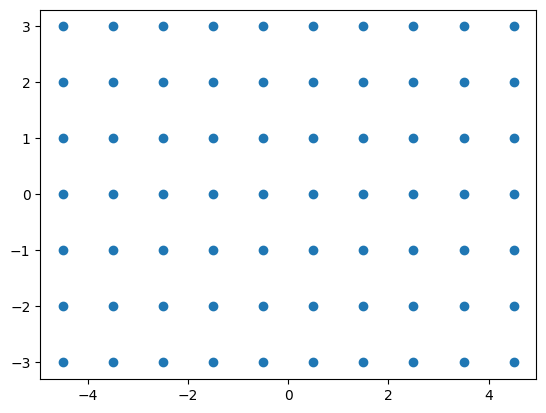

In [15]:
######################
## Chessboard model ##
######################
def checkerboard_points(n,m):
    Q = np.zeros(shape=(3, n*m))
    for i in range(n):
        for j in range(m):
            Q[:, i*m+j] = [i - (n-1)/2.0,
                        j - (m-1)/2.0,
                        0]
                
    return Q

checkerboard = checkerboard_points(10,7)
print("shape:", checkerboard.shape)
plt.scatter(checkerboard[0,:], checkerboard[1,:])


**Now** Either calibratecamera(qs, Q) from last week, or cv2's built in calibratecamera to calibrate the camera.

In [16]:
qs = []
for i in range(len(imgpoints)):    
    r, _, c = imgpoints[i].shape
    q_ = np.zeros(shape=(c, r))
    q_[0, :] = imgpoints[i][:,0,0]
    q_[1, :] = imgpoints[i][:,0,1]
    qs.append(q_)


8


In [17]:
############
# Homemade #
############ 
print(qs[0].shape)
print(checkerboard.shape)
K_homemade, Rs_homemade, ts_homemade = utilis.calibrate_camera(qs, checkerboard)

(2, 70)
(3, 70)


In [18]:
K_homemade#, ts

array([[593.52078195,  -2.27545806, 299.57268839],
       [  0.        , 297.04626983, 200.47900435],
       [  0.        ,   0.        ,   1.        ]])

**objpoints** should be a list of (n · m) × 3 arrays in np.float32. Each list element contains the 3D \
points of the checkerboard for each camera (from checkerboard_points).

In [40]:
objpoints = [np.float32(checkerboard.T)]
print(len(objpoints))
while len(objpoints)<len(imgpoints):
    objpoints.append(np.float32(checkerboard.T))
print(checkerboard[:,0])
print(objpoints[0][0])

1
[-4.5 -3.   0. ]
[-4.5 -3.   0. ]


In [20]:
############
# Built in #
############
ret, K_cv2, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None, 
        flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
        cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST
    )

#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Distortion is set to 0, so d-vector will be zeroes:", distortion_coefficients)
np.asarray(tvecs).shape

Distortion is set to 0, so d-vector will be zeroes: [[0. 0. 0. 0. 0.]]


(8, 3, 1)

In [21]:
print("CV2 K-matrix\n",K_cv2,"\n'Home-made' K matrix\n", K_homemade)

CV2 K-matrix
 [[619.02163033   0.         301.34671742]
 [  0.         307.78047923 188.88678079]
 [  0.           0.           1.        ]] 
'Home-made' K matrix
 [[593.52078195  -2.27545806 299.57268839]
 [  0.         297.04626983 200.47900435]
 [  0.           0.           1.        ]]


#### 5.8 ReProject the points

Reproject the checkerboard corners to the images. \
**NB**: cv2.calibrateCamera returns rvecs, which are the R matrices stored in axis-angle representation. You can convert them to rotation matrices with cv2.Rodrigues.

In [22]:
Rs_cv2 = []
for rvec in rvecs:
    R, _ = cv2.Rodrigues(rvec)
    Rs_cv2.append(R)

ts_cv2 = np.asarray(tvecs)

In [23]:
print(np.asarray(ts_homemade)[0].reshape(3,1).shape)
print(ts_cv2[0].shape)

(3, 1)
(3, 1)


In [24]:
i = 0
reprojection_boards_cv2 = []
reprojection_boards_homemade = []

qs_cv2 = []
qs_homemade = []

for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        # Make copies to draw on
        cpy_cv2 = img.copy()
        cpy_homemade = img.copy()
        # Projection matrices
        P_cv2       = K_cv2         @   np.hstack((Rs_cv2[i], ts_cv2[i]))
        P_homemade  = K_homemade    @   np.hstack((Rs_homemade[i], ts_homemade[i].reshape(3,1)))
        # Project
        qh_cv2 = P_cv2 @ np.vstack((checkerboard, np.ones(len(checkerboard[0]))))
        qh_homemade = P_homemade @ np.vstack((checkerboard, np.ones(len(checkerboard[0]))))
        # Inhomogenous coordinates
        q_cv2 = qh_cv2[0:2, :]/qh_cv2[2, :]
        q_homemade = qh_homemade[0:2, :]/qh_homemade[2, :]
        qs_cv2.append(q_cv2)
        qs_homemade.append(q_homemade)
        # Draw all points onto images
        for k in range(len(q_cv2[0])):
            # Using cv2 built in
            row = int(q_cv2[0,k])
            col = int(q_cv2[1,k])
            cv2.circle(img=cpy_cv2, center=(row, col), radius =1, color =(255,0,0), thickness=4)
            # Using homemade
            row = int(q_homemade[0,k])
            col = int(q_homemade[1,k])
            cv2.circle(img=cpy_homemade, center=(row, col), radius =1, color =(255,0,0), thickness=4)

        reprojection_boards_cv2.append(cpy_cv2)
        reprojection_boards_homemade.append(cpy_homemade)

        i+=1

Text(0.5, 1.0, 'Homemade')

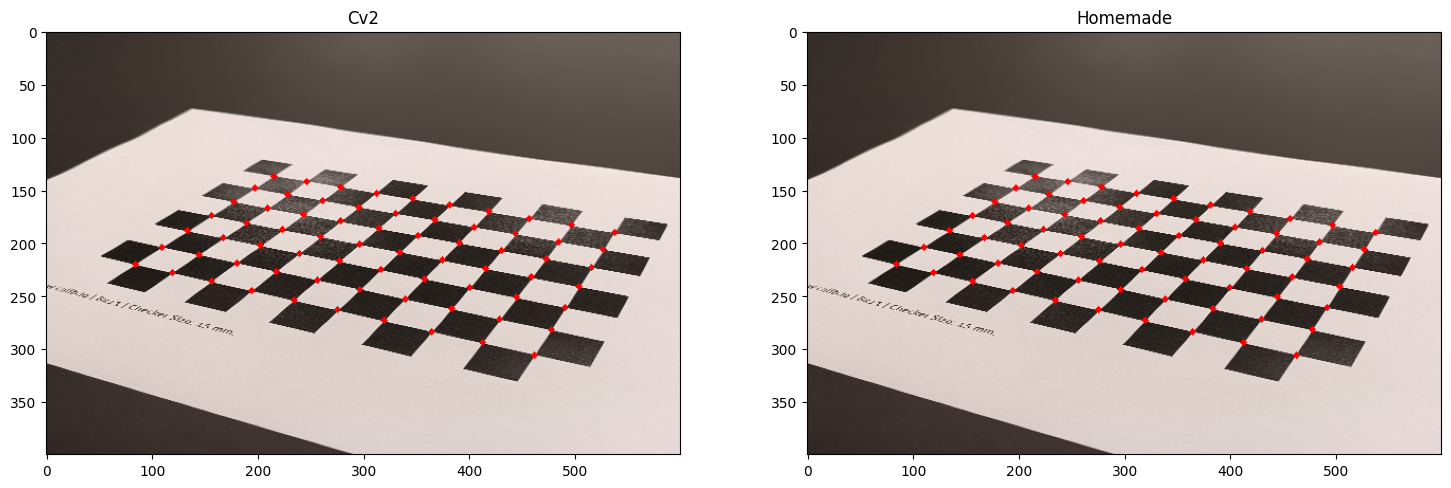

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(reprojection_boards_cv2[7])
ax[0].set_title('Cv2')
ax[1].imshow(reprojection_boards_homemade[7])
ax[1].set_title('Homemade')

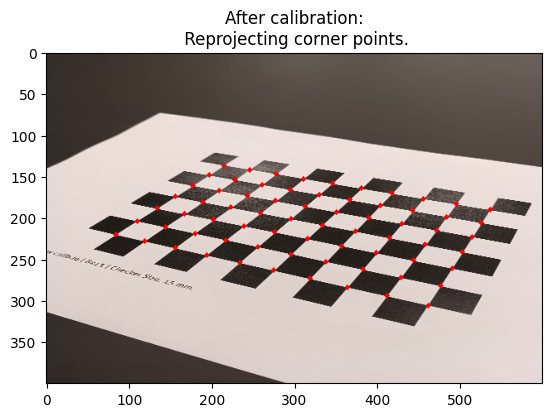

In [26]:
plt.imshow(reprojection_boards_homemade[7])
plt.title("After calibration:\n Reprojecting corner points.");

**Calculate reprojection error** by comparing detected vs projected corners.

In [27]:
######################################################################################
### qs holds all detected corners, while qs_homemade holds all reprojected points. ###
######################################################################################
RMSEs = np.zeros(len(qs))
for i in range(len(qs)):
    RMSE = np.sqrt(np.mean((qs[i]-qs_homemade[i])**2))
    RMSEs[i] = RMSE

In [28]:
print("Our biggest error is to be found in image no.", RMSEs.argmax()+1)
print("The RMSE value of this image is", RMSEs.max())

Our biggest error is to be found in image no. 4
The RMSE value of this image is 0.4191506207569166


In [29]:
#####################################
## First draw the detected corners ##
#####################################
detected_drawings = []
for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10))
    if ret == True:
        # Draw style 1
        painted = cv2.drawChessboardCorners(img.copy(), (7, 10), corners,ret)
        detected_drawings.append(painted)

Text(0.5, 1.0, 'Projected point')

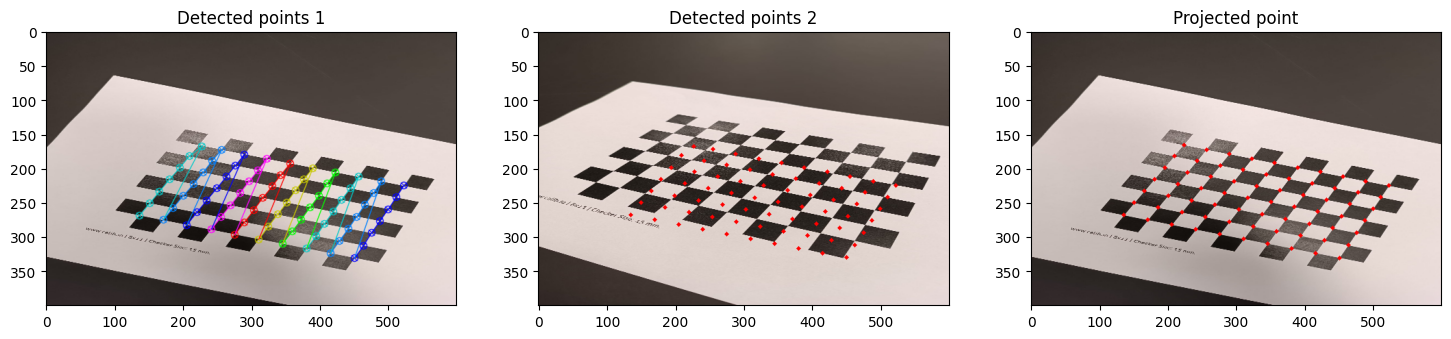

In [30]:
###########################################
## Alternatively just use qs from before ##
###########################################
points = qs[RMSEs.argmax()]
painted_2 = images[18].copy()
for i in range(len(points[0])):
    row = int(points[0,i])
    col = int(points[1,i])
    cv2.circle(img=painted_2, center=(row, col), radius =1, color =(255,0,0), thickness=4)

#######################
## Then compare them ##
#######################

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,18))
ax[0].imshow(detected_drawings[RMSEs.argmax()])
ax[0].set_title('Detected points 1')
ax[1].imshow(painted_2)
ax[1].set_title('Detected points 2')
ax[2].imshow(reprojection_boards_homemade[RMSEs.argmax()])
ax[2].set_title('Projected point')

**So** what is happening here?
- The reprojected points are relying on the checkerboard model "Q": which contains exact checkerboard coordinates.
- The detection algorithm struggles to find the exact corners, du to the reflection on the paper.
- Therefore, the projected point hits the corners "more accurate" than the detection algorithm!

But don't we use the badly detected corners to calibrate in the first place? Yes we do! But this becomes less and less of a problem when we have enough pictures to use.

In [31]:
##### EASIER VERSION?
q = []
scale = 0.25
imsize = None
imgs = []
for i in range(20):
    im = cv2.imread(f'images/checkboards/C{i+1}.jpg')[:,:,::-1]
    im = cv2.resize(im, None, fx=scale, fy=scale)
    if not imsize: imsize = im.shape
    imgs.append(im)

to_del = []
for i, im in enumerate(imgs):
    res = cv2.findChessboardCorners(im, (7, 10))
    if not res[0]:
        print(f'No corners found for C{i+1}.jpg')
        to_del.append(i)
    else:
        q.append(res[1])

# delete images for which no corners were found
to_del.sort(reverse=True)
for index in to_del:
    del imgs[index]


print(imsize[1::-1])

No corners found for C10.jpg
No corners found for C16.jpg
(375, 500)


In [32]:
def checkerboard_points(n, m):
    Q = []
    for i in range(n):
        for j in range(m):
            Q.append(np.array([[i-(n-1)/2, j-(m-1)/2, 0]]).astype(np.float32))
    return np.vstack(Q).T
Q = checkerboard_points(10, 7).T
Qs = []
for i in range(len(q)):
    Qs.append(Q)

flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(Qs, q, imsize[1::-1], None, None, flags=flags)

print(ret)
print(K)

0.6150622638315268
[[393.77979647   0.         182.26952879]
 [  0.         391.79967264 231.38685601]
 [  0.           0.           1.        ]]


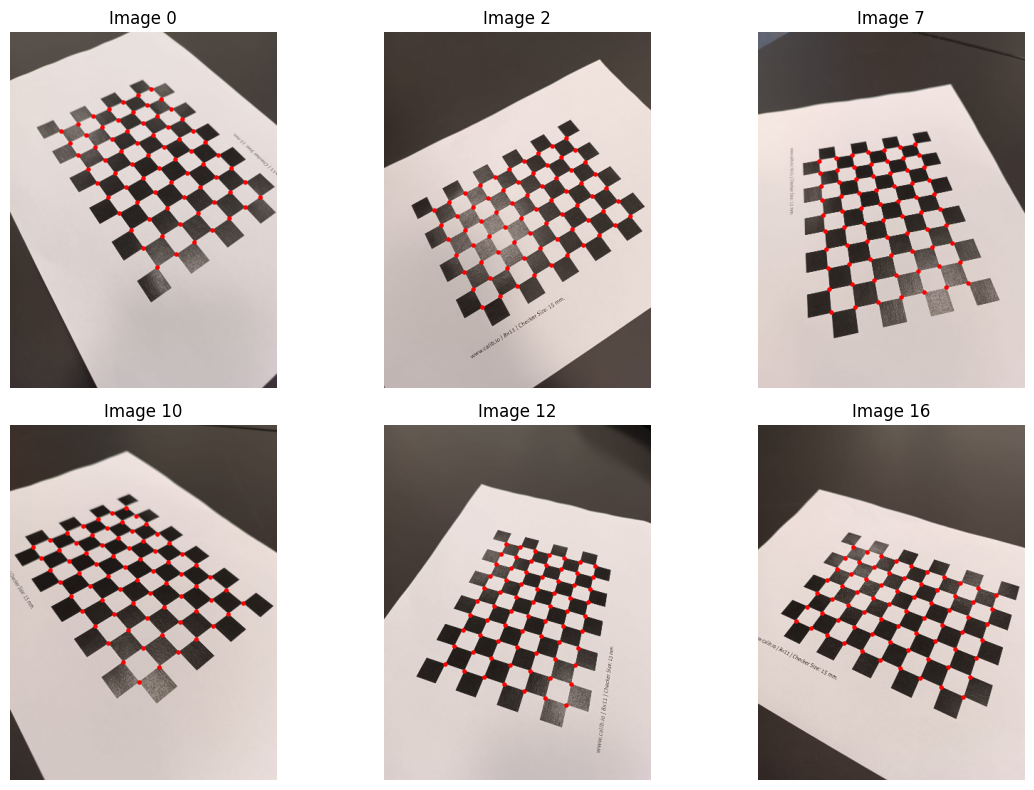

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
idxs = [0, 2, 7, 10, 12, 16]
for i, idx in enumerate(idxs):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Plot image
    ax.imshow(imgs[idx])

    R = cv2.Rodrigues(rvecs[idx])[0]
    t = tvecs[idx].T

    proj = utilis.projectpoints(K, R, t.T, Q.T)

    # Plot projected points
    ax.scatter(proj[0], proj[1], marker='o', color='r', s=5)

    ax.set_title(f'Image {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

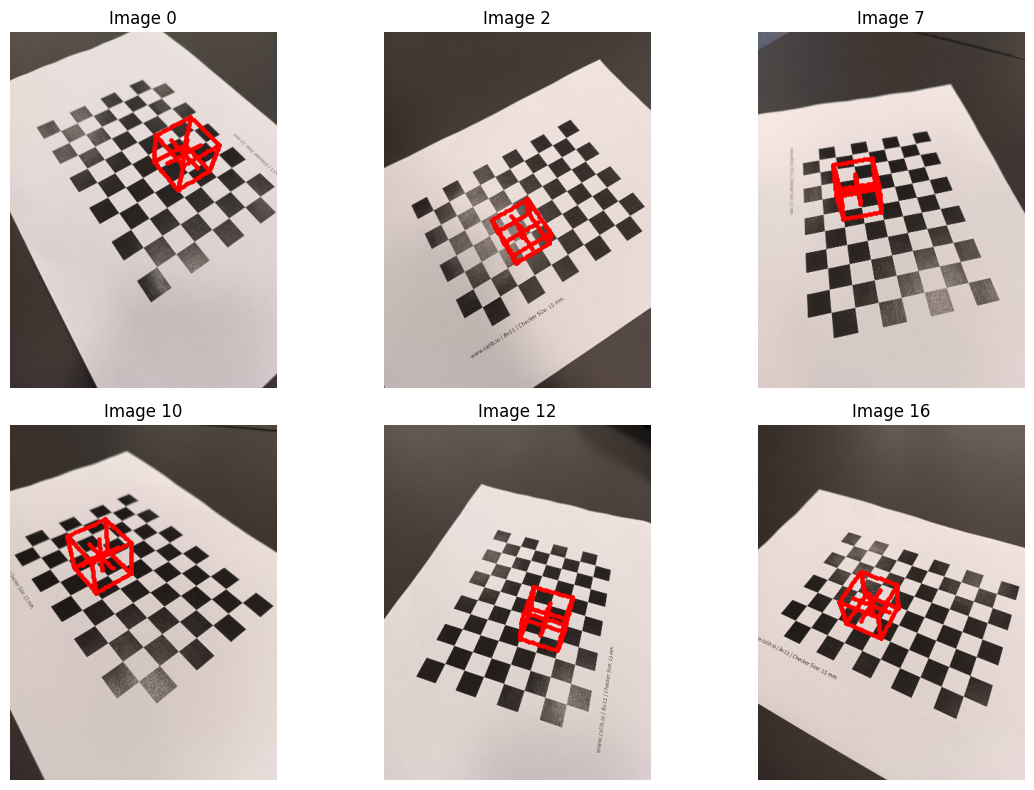

In [34]:
import itertools as it
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

Qbox = 2*box3d() + 1

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
idxs = [0, 2, 7, 10, 12, 16]
for i, idx in enumerate(idxs):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Plot image
    ax.imshow(imgs[idx])

    R = cv2.Rodrigues(rvecs[idx])[0]
    t = tvecs[idx].T

    proj = utilis.projectpoints(K, R, t.T, Qbox)

    # Plot projected points
    ax.scatter(proj[0], proj[1], marker='o', color='r', s=5)

    ax.set_title(f'Image {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()